In [17]:
import midynet
import midynet.util.display as display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pathlib
import numpy as np
import fractions


plot = midynet.metrics.Statistics.plot

display.setup_dir("./")

## Loading data from experiment

In [18]:


exp = {}
bit_ratio = np.log(2)
hg, hx, hgx, hxg, mi = {}, {}, {}, {}, {}

all_dynamics = ["ising", "sis", "cowan"]
for dynamics in all_dynamics:
    path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure2/exact-{dynamics}/")
    if (path_to_data / "config.pickle").exists():
        exp[dynamics] = midynet.experiments.Experiment.load_from_file(path_to_data / "config.pickle")
        hg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hg-{k}"] for k in ["mid", "high", "low"]})
        hx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hx-{k}"] for k in ["mid", "high", "low"]})
        hgx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hgx-{k}"] for k in ["mid", "high", "low"]})
        hxg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hxg-{k}"] for k in ["mid", "high", "low"]})
        mi[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"mi-{k}"] for k in ["mid", "high", "low"]})

xlabel = r"Number of time steps"
titles = {"ising": r"(a) Glauber", "sis": r"(b) SIS", "cowan": r"(c) Cowan"}
couplingLabels = {"ising": r"J\langle k \rangle", "sis": r"\frac{\alpha \langle k \rangle}{\beta}", "cowan": r"\nu\langle k \rangle"}

## Figure 2 revisited

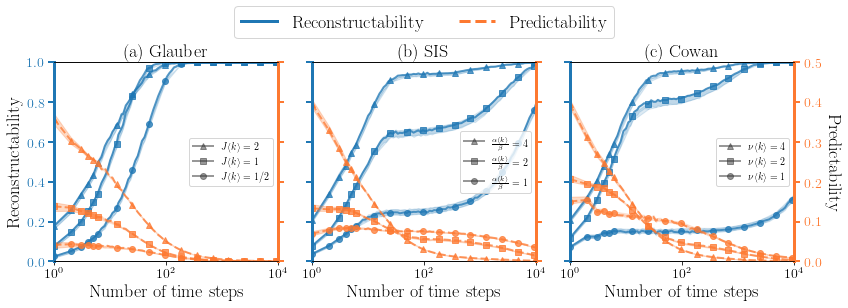

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax = {dynamics: ax[i] for i, dynamics in enumerate(all_dynamics)}
axx = {dynamics: ax[dynamics].twinx() for i, dynamics in enumerate(all_dynamics)}


recon_color = display.med_colors["blue"]
pred_color = display.dark_colors["orange"]


spacing = 7
min_index = 5

markers = ["o", "s", "^", "*"]
for dynamics_id, dynamics in enumerate(all_dynamics):
    if dynamics not in exp:
        continue
    x = np.array(exp[dynamics].config.dynamics.num_steps)
    m_indices = list(range(min_index)) + list(range(min_index, len(x), spacing))
    coupling = exp[dynamics].config.dynamics.get_coupling()
    if dynamics == "sis":
        coupling = [c / exp[dynamics].config.dynamics.recovery_prob for c in coupling]
    alpha = np.linspace(0, 1, len(coupling) + 2)[2:] ** 1.5
    recon = mi[dynamics] / hg[dynamics]
    pred = mi[dynamics] / hx[dynamics]
    for c_index, (c, a) in reversed(list(enumerate(zip(coupling, alpha)))):
        
        y = recon if len(coupling) == 1 else recon[:, c_index]
        plot(
            ax[dynamics], 
            x, y,
            color=recon_color,
            alpha=0.75,
            linestyle="-",
            marker="None",
        )
        y = recon[m_indices] if len(coupling) == 1 else recon[m_indices, c_index]
        plot(
            ax[dynamics], 
            x[m_indices], y,
            color=recon_color,
            alpha=0.75,
            linestyle="None",
            marker=markers[c_index],
            markersize=6,
        )
        
        
        y = pred if len(coupling) == 1 else pred[:, c_index]
        plot(
            axx[dynamics], 
            x, y,
            color=pred_color,
            alpha=0.75,
            linestyle="--",
            marker="None",
        )
        y = pred[m_indices] if len(coupling) == 1 else pred[m_indices, c_index]
        plot(
            axx[dynamics], 
            x[m_indices], y,
            color=pred_color,
            alpha=0.75,
            linestyle="None",
            marker=markers[c_index],
            markersize=6,
        )
    
    if dynamics_id == 0:
        ax[dynamics].set_ylabel(r"Reconstructability", fontsize=18)
        
    if dynamics_id == len(all_dynamics)-1:
        axx[dynamics].set_ylabel(r"Predictability", fontsize=18, rotation=-90, rotation_mode="anchor", va="bottom")
    else:
        axx[dynamics].axes.xaxis.set_ticklabels([])
        axx[dynamics].axes.yaxis.set_ticklabels([])
    ax[dynamics].set_xlabel(xlabel, fontsize=18)
    ax[dynamics].tick_params(axis='both', labelsize=14)
    ax[dynamics].set_xlim([1, 1000])
    ax[dynamics].set_ylim([0., 1.])
    ax[dynamics].set_xscale("log")
    ax[dynamics].set_title(titles[dynamics], fontsize=18)
    
    axx[dynamics].set_xlabel(xlabel, fontsize=18)
    axx[dynamics].tick_params(axis='both', labelsize=14)
    axx[dynamics].set_xlim([1, 1e4])
    axx[dynamics].set_xscale("log")
    axx[dynamics].set_ylim([0, 0.5])
    
    handles = [
        Line2D([0], [0], marker=markers[i], linestyle="-", color=display.dark_colors["grey"], label=rf"${couplingLabels[dynamics]} = {fractions.Fraction(c)}$", alpha=0.5)
        for i, c in reversed(list(enumerate(coupling)))
    ]
    ax[dynamics].legend(handles=handles, loc="center right", fontsize=10, ncol=1, frameon=True)
    
#     display.Label.plot(ax[dynamics], loc="top right",fontsize=18)
#     ax[dynamics].tick_params(axis='y', colors=recon_color)
#     axx[dynamics].tick_params(axis='y', colors=pred_color)
    axx[dynamics].spines['left'].set_color(recon_color)
    axx[dynamics].spines['left'].set_linewidth(3)
    axx[dynamics].spines['right'].set_color(pred_color)
    axx[dynamics].spines['right'].set_linewidth(3)
    
    ax[dynamics].tick_params(axis='y', colors=recon_color, length=6, width=2)
    axx[dynamics].tick_params(axis='y', colors=pred_color, length=6, width=2)

handles = [Line2D([0], [0], marker="None", linestyle="-", color=recon_color, label=r"Reconstructability", alpha=1, linewidth=3)]
handles += [Line2D([0], [0], marker="None", linestyle="--", color=pred_color, label=r"Predictability", alpha=1, linewidth=3)]
lg = fig.legend(handles=handles, loc="center", fontsize=18, ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
fig.savefig(f"./svg/p1-figure2rev.svg", bbox_extra_artists=(lg,), bbox_inches='tight')
fig.savefig(f"./pdf/p1-figure2rev.pdf", bbox_extra_artists=(lg,), bbox_inches='tight')
fig.savefig(f"./png/p1-figure2rev.png", bbox_extra_artists=(lg,), bbox_inches='tight')

In [61]:
from scipy.optimize import bisect
def sigmoid(x):
    return 1 / (np.exp(-x) + 1)

def wc_thresholds(a=4, b=0.5, m=1):
    def h(x, c):
        return -b * x + (1 - x) * sigmoid(a * (c * x - m))

    def f1_to_solve(c):
        q = c * a
        x = (1 + np.sqrt(1 - 4 * (1 + b)/ q)) / (2 * (1 + b))
        return h(x, c)

    def f2_to_solve(c):
        q = c * a
        x = (1 - np.sqrt(1 - 4 * (1 + b)/ q)) / (2 * (1 + b))
        return h(x, c)
    c1, c2 = None, None
    if np.sign(f1_to_solve(4 * (1 + b) / a)) != np.sign(f1_to_solve(100)):
        c1 = bisect(f1_to_solve, a=4 * (1 + b) / a, b=100)
    if np.sign(f2_to_solve(4 * (1 + b) / a)) != np.sign(f2_to_solve(100)):
        c2 = bisect(f2_to_solve, a=4 * (1 + b) / a, b=100)
    return c1, c2

In [141]:
t, _ = wc_thresholds(a=exp["cowan"].config.dynamics.a, b=exp["cowan"].config.dynamics.eta, m=exp["cowan"].config.dynamics.mu)


In [59]:
x

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 23,
 24,
 26,
 28,
 30,
 32,
 35,
 37,
 40,
 43,
 46,
 49,
 53,
 57,
 61,
 65,
 70,
 75,
 81,
 86,
 93,
 100,
 107,
 114,
 123,
 132,
 141,
 151,
 162,
 174,
 187,
 200,
 215,
 231,
 247,
 265,
 284,
 305,
 327,
 351,
 376,
 403,
 432,
 464,
 497,
 533,
 572,
 613,
 657,
 705,
 756,
 811,
 869,
 932,
 1000]

In [52]:
slice(list(range(10)) + list(range(10, 100, 10)))

slice(None, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90], None)

In [13]:
exp["cowan"].config.dynamics

DynamicsConfig(name=`cowan`, num_steps=`[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 23, 25, 28, 31, 34, 37, 41, 45, 49, 54, 59, 65, 72, 79, 86, 95, 104, 114, 126, 138, 151, 166, 183, 200, 220, 242, 265, 291, 319, 351, 385, 422, 464, 509, 559, 613, 673, 739, 811, 890, 977, 1072, 1176, 1291, 1417, 1555, 1707, 1873, 2056, 2257, 2477, 2718, 2983, 3274, 3593, 3944, 4328, 4750, 5214, 5722, 6280, 6892, 7564, 8302, 9111, 10000]`, nu=`[1, 2, 4]`, a=`8.0`, mu=`1.0`, eta=`0.5`, normalize=`True`)